In [77]:
# Bibliotecas
from bibkmis.auxkmis import *
from bibkmis.typeskmis import SOLUCAO, KMIS

import ast                      # Ler os litearias de tipos simples
import os                       # Controle de pastas
from copy import deepcopy as dc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np              # Principal para ferramentas matematicas
from tqdm import tqdm           # Barrinha de progresso

path_save = "analise_resultados/"
path_AP   = "arquivos_principais/"


para_latex = {
  'ANT_VND'  : r"ANT\_VND",
  'ANT2_VND'  : r"ANT$'$\_VND",
  'ANT_VND2' : r"ANT\_VND$'$",
  'ANT2_VND2': r"ANT$'$\_VND$'$",
  'ANT_TS'   : r"ANT\_TS",
  'ANT2_TS'  : r"ANT$'$\_TS",
  'GRASP_RG_TS' : r"GRASP\_RG\_TS",
  'GRASP_RG_VND' : r"GRASP\_RG\_VND",
  'GRASP_RG_VND2' : r"GRASP\_RG\_VND$'$",
  'KIEst' : r"HG\_Est"
}

# Restaurando Instâncias para consulta
dictI = {
  "id": [], "kmis": [], "p": [], "k": [],
  "|L|": [], "|R|": [], "L": [], 'temSol': [], 'classe': []
}
dfI = pd.DataFrame(columns = list(dictI.keys()))
# ==== Carregamento de Instâncias Salvas =====
conv = {
  'L'     : ast.literal_eval,
  'temSol': ast.literal_eval,
  'L_b14' : ast.literal_eval,
  'Llabel': ast.literal_eval,
  'Rlabel': ast.literal_eval
}
try:
  dfI = pd.read_csv(path_AP+'instancias.csv', converters=conv)
  print(f'Leitura de instancias.csv ({dfI.shape[0]} linhas) bem sucedida.')
except:
  print('\n\n\t\tArquivo instancias não encontrado!!\n\n')
  assert dfI.shape[0]>0 , "Sem instâncias não continua! Peque o arquivo 'instancias.csv'."

# Reinstanciar objetos KMIS a partir das linhas do CSV
dictI['kmis_b14'] = []
with tqdm(total = dfI.shape[0], smoothing = 0.001, desc="Reconstruindo Instâncias") as pbar:
  for _, row in dfI.iterrows():
    kmis = KMIS(row['|L|'], row['|R|'], row['p'], row['k'], row['L'])
    kmis_reduzido = KMIS(row['|L|_b14'], row['|R|_b14'], row['p'], row['k'], row['L_b14'])
    kmis_reduzido.Llabel = row['Llabel_b14']
    kmis_reduzido.Rlabel = row['Rlabel_b14']
    dictI['kmis'].append(kmis)
    dictI['kmis_b14'].append(kmis_reduzido)
    pbar.update(1)

dfI['kmis'] = dictI['kmis']
dfI['kmis_b14'] = dictI['kmis_b14']

# Leitura das tabelas:
try:
  dfAT  = pd.read_csv(path_AP+'teste_parametros.csv')
  dfRT  = pd.read_csv(path_AP+'resultados.csv')
  dfIRT = pd.read_csv(path_AP+'resultados_reduzidas.csv')
except:
  print('Tem arquivo faltante!')

Leitura de instancias.csv (540 linhas) bem sucedida.


Reconstruindo Instâncias: 100%|██████████| 540/540 [00:02<00:00, 209.78it/s] 


In [78]:
test = pd.DataFrame({'H':['ANT_VND', 'ANT2_TS','GRASP_RG_VND2' ,'ANT_VND',], 'V':[1,2,3,4]})
test['H'].apply(lambda x: para_latex[x])

0             ANT\_VND
1           ANT$'$\_TS
2    GRASP\_RG\_VND$'$
3             ANT\_VND
Name: H, dtype: object

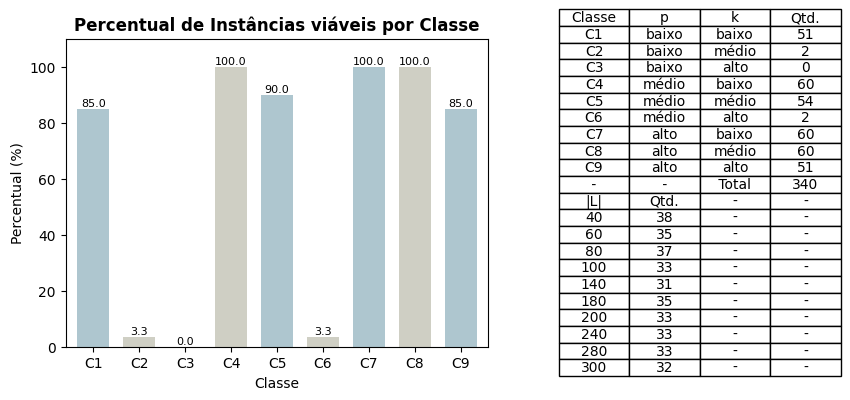

In [79]:
"""Caracteristicas das Instâncias"""

# ========= Gráfico  ===========
# Contagens por classe
tamanhos_L = dfI[dfI['temSol']]['|L|'].value_counts().reset_index().sort_values(by='|L|')
MAX_TAMANHO_L : int = int(tamanhos_L['|L|'].max())
qtdTotal = dfI.groupby('classe')['temSol'].count()
qtdTrue  = dfI[dfI['temSol']].groupby('classe')['temSol'].count()
qtdTrue  = qtdTrue.reindex(dfI['classe'].unique(), fill_value=0)
percentual = (qtdTrue/qtdTotal)*100
percentual = percentual.astype(float)

# Criando a figura
_, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [3, 2]})

# Gráfico de barras
cores = ['#AEC6CF', '#CFCFC4']
percentual.plot(kind='bar', color=cores[:len(percentual)], ax=ax[0], width=0.7)

for i, v in enumerate(qtdTrue):
    ax[0].text(i, percentual.iloc[i] + 1, f'{percentual.iloc[i]:.1f}', ha='center', fontsize=8)

ax[0].set_xticklabels(percentual.index, rotation=0)
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Percentual (%)')
ax[0].set_title('Percentual de Instâncias viáveis por Classe', fontweight='bold')
ax[0].set_ylim(0, 110)

# Construindo a tabela
Clabel = {0.1:'baixo', 0.4:'médio', 0.7:'alto'}
tabela_dados = [[v, f'{Clabel[k[0]]}', f'{Clabel[k[1]]}'] for k, v in classes.items()]
for i in tabela_dados:
    i.append(str(qtdTrue.loc[i[0]]))
tabela_dados.append([' - ', ' - ', ' Total ', f'{qtdTrue.sum()}'])

# Adicionando os tamanhos únicos de |L|
tabela_dados.append(['|L|', 'Qtd.', '-', '-'])
for _, row in tamanhos_L.iterrows():
    tabela_dados.append([f'{row["|L|"]}', row['count'],'-', '-'])

# Exibindo a tabela com destaque visual
col_labels = ['Classe', 'p', 'k', 'Qtd.']
ax[1].axis('tight')
ax[1].axis('off')
ax[1].table(cellText=tabela_dados,
            colLabels=col_labels,
            loc='center', cellLoc='center')

plt.show()


In [80]:

"""Analise da Redução"""
# =============================================================================== 
# dfI_temSol = dfI[dfI['temSol']].reset_index()
# #print((dfI_temSol['tempo_reducao']).describe())
# #display(dfI_temSol[['classe', 'classe_b14']])
# dfReducao = pd.DataFrame({'Mudanca_Classe':dfI_temSol[['classe', 'classe_b14']].apply(lambda x: f'{x.iloc[0]} ->  {x.iloc[1]}', axis=1)})
# dfReducao.value_counts().to_csv(path_save+'mudanca_de_classes.csv')

# tamanhos_L_b14 = dfI_temSol['|L|_b14'].value_counts().reset_index().sort_values(by='|L|_b14')
# qtdTotal_b14 = dfI.groupby('classe')['id'].count()
# qtdTrue_b14  = dfI_temSol.groupby('classe_b14')['id'].count()
# qtdTrue_b14  = qtdTrue_b14.reindex(dfI['classe'].unique(), fill_value=0)
# percentual_b14 = (qtdTrue_b14/qtdTotal_b14)*100
# percentual_b14 = percentual_b14.astype(float)
# change_b14 = (qtdTrue_b14 - qtdTrue).astype(float)

# # Cores condicionais
# colors = ['lightblue' if val < 0 else 'darkseagreen' for val in change_b14]

# # Criação do gráfico
# fig, ax = plt.subplots()
# change_b14.plot(kind='bar', ax=ax, color=colors, width=0.8)
# # Adiciona os valores sobre ou dentro das barras
# for i, val in enumerate(change_b14):
#   if val !=0:
#     ax.text(i, val-0.8 if val >= 0 else val + 0.7,  # Ajuste da posição vertical
#             f'+{val}' if val >= 0 else f'{val}',                      # Valor formatado
#             ha='center', va='bottom' if val >= 0 else 'top',  # Alinhamento vertical
#             fontsize=10, color='black')         # Estilo do texto

# # Ajustes estéticos conforme ABNT
# ax.set_xticks(range(len(change_b14.index)))
# ax.set_xticklabels(change_b14.index, rotation=0, fontsize=10)
# ax.set_xlabel('Classe', fontsize=12)
# ax.set_ylabel('Diferença\n(quantidade pós redução menos anterior)', fontsize=10)
# ax.set_title('Diferença de instâncias viáveis por classe pós redução', fontsize=14)

# # Adição de grade (comumente usada para facilitar leitura)
# ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# # Remoção da borda superior e direita
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

#plt.tight_layout()
# plt.savefig('tamanho_classe_diferenca_pos_reducao.pdf', format='pdf', bbox_inches='tight')
#plt.show()

'Analise da Redução'

In [81]:
"""    Teste de parametros resultado    """

# ==================== Formatando e obtendo as estatisticas desejadas ================
assert isinstance(dfAT, pd.DataFrame), '\t ⚠️ DataFrame dfAT não definido.'
teste_consistencia(dfI, dfAT)

df_ai  = dfAT.groupby(['idH', 'idArg', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
df_a   = df_ai.groupby(['idH', 'idArg'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
df_i   = df_ai.groupby(['idH', 'idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()

# Comparações
cmp            = df_ai.merge(df_i, on=['idH', 'idI'])
cmp['eq_vmin'] = cmp['vmin']  ==  cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax']  ==  cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)

# Contagem e merge  final
cnt = cmp.groupby(['idH', 'idArg'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
dfA = df_a.merge(cnt, on=['idH', 'idArg'])

df_limites   = dfA.groupby(['idH'])[dfA.columns[2:]].apply(limites_argumento).reset_index()
df_score     = dfA.merge(df_limites, on=['idH'])
dfA['score']  = df_score.apply(score_time_off, axis=1)


top10 = dfA.groupby(['idH'])[dfA.columns[1:]].apply(lambda g: g.nlargest(10, 'score'))
top10.to_csv(path_save+'top10_teste_parametros.csv')
display(top10)


	✓ Todos os ids estão presentes em dfI.


idArg     mvmin     mvavg  \
idH                                                                          
ANT_VND     60   (1, 1.2, 0.1, 0.9, 0.1, 5, 10000, 10)  7.970588  8.247059   
            33   (1, 0.8, 0.1, 0.9, 0.1, 5, 10000, 10)  7.970588  8.235294   
            69   (1, 1.2, 0.3, 0.9, 0.1, 5, 10000, 10)  7.970588  8.226471   
            80   (1, 1.2, 0.5, 0.9, 0.3, 5, 10000, 10)  7.911765  8.250000   
            71   (1, 1.2, 0.3, 0.9, 0.3, 5, 10000, 10)  7.941176  8.226471   
            78   (1, 1.2, 0.5, 0.9, 0.1, 5, 10000, 10)  7.882353  8.250000   
            61   (1, 1.2, 0.1, 0.9, 0.2, 5, 10000, 10)  7.941176  8.258824   
            70   (1, 1.2, 0.3, 0.9, 0.2, 5, 10000, 10)  7.911765  8.244118   
            34   (1, 0.8, 0.1, 0.9, 0.2, 5, 10000, 10)  7.882353  8.182353   
            42   (1, 0.8, 0.3, 0.9, 0.1, 5, 10000, 10)  7.882353  8.208824   
GRASP_RG_TS 104               (0.8, 0.3, 5, 10000, 10)  8.176471  8.408824   
            102              (0.8, 0.3, 10, 10000, 10)  8.147059  8.385294   
            101               (0.8, 0.1, 5, 10000, 10)  8.147059  8.414706   
            99               (0.8, 0.1, 10, 10000, 10)  8.205882  8.382353   
            91               (0.5, 0.1, 15, 10000, 10)  8.147059  8.373529   
            93               (0.5, 0.3, 10, 10000, 10)  8.147059  8.382353   
            100              (0.8, 0.1, 15, 10000, 10)  8.147059  8.394118   
            103              (0.8, 0.3, 15, 10000, 10)  8.176471  8.373529   
            107               (0.8, 0.5, 5, 10000, 10)  8.176471  8.408824   
            97               (0.5, 0.5, 15, 10000, 10)  8.117647  8.341176   

                    mvmax     mtavg  cnt_vmin  cnt_vavg  cnt_vmax  cnt_tavg  \
idH                                                                           
ANT_VND     60   8.558824  6.178938        28        19        28         1   
            33   8.470588  6.178977        28        18        26         0   
            69   8.529412  6.178988        28        16        27         2   
            80   8.529412  6.178890        26        17        27         2   
            71   8.529412  6.178908        27        16        27         3   
            78   8.500000  6.178933        25        17        26         4   
            61   8.441176  6.178975        27        17        24         1   
            70   8.500000  6.179198        26        15        26         0   
            34   8.529412  6.178935        25        16        26         3   
            42   8.529412  6.178958        25        15        26         2   
GRASP_RG_TS 104  8.735294  6.189845        32        22        31         0   
            102  8.764706  6.184895        31        19        32         0   
            101  8.735294  6.188786        31        19        30         0   
            99   8.705882  6.187247        33        17        30         1   
            91   8.735294  6.181647        31        19        30         2   
            93   8.735294  6.182863        31        18        30         1   
            100  8.705882  6.183800        31        17        30         1   
            103  8.676471  6.186358        32        18        29         1   
            107  8.588235  6.188828        32        21        26         0   
            97   8.764706  6.181087        30        17        31         2   

                   score  
idH                       
ANT_VND     60   99.8275  
            33   95.8043  
            69   94.4594  
            80   94.2776  
            71   93.5294  
            78   92.2813  
            61   92.1376  
            70   90.4583  
            34   90.3412  
            42   89.3958  
GRASP_RG_TS 104  94.6342  
            102  88.8766  
            101  87.1216  
            99   85.1854  
            91   84.0105  
            93   83.2486  
            100  81.4589  
            103  81.0260  
            107  80.1374  
            97   79.0148

In [82]:
"""   Analise dos resultados geral    """

# ===========================================================================================
assert isinstance(dfRT, pd.DataFrame), '\t ⚠️ DataFrame do teste final não definido.'
teste_consistencia(dfI, dfRT)

dfR_hi = dfRT.groupby(['idH', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
dfR_h  = dfR_hi.groupby(['idH'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
dfR_i  = dfR_hi.groupby(['idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()
# Comparações
cmp = dfR_hi.merge(dfR_i, on=['idI'])
cmp['eq_vmin'] = cmp['vmin'] == cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax'] == cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)

# Contagem e merge final
cnt = cmp.groupby(['idH'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
dfR = dfR_h.merge(cnt, on=['idH'])
df_limites = limites_argumento(dfR).to_frame().T
df_score = dfR.merge(df_limites, how='cross')
dfR['score'] = df_score.apply(score_time_off, axis=1)
display(dfR.sort_values('score', ascending=False).drop(columns=['mtavg', 'cnt_tavg']))
dfR.to_csv(path_save+'resultados_geral_intancia_base.csv', index = False)
#print(dfR.sort_values('score', ascending=False).drop(columns=['mtavg', 'cnt_tavg']).to_latex(escape=False, index=False, float_format=lambda x: f'{x:.2f}'))


	✓ Todos os ids estão presentes em dfI.


,idH,mvmin,mvavg,mvmax,cnt_vmin,cnt_vavg,cnt_vmax,score
8,GRASP_RG_VND2,5.982353,6.132941,6.273529,303,276,320,100.0000
7,GRASP_RG_VND,5.947059,6.097647,6.247059,291,259,313,84.3122
6,GRASP_RG_TS,5.944118,6.073824,6.229412,292,242,305,75.4661
2,ANT2_VND2,5.835294,6.025294,6.214706,255,211,301,44.5738
9,KIEst,5.932353,5.932353,5.932353,288,237,235,32.8595
0,ANT2_TS,5.800000,5.996176,6.208824,243,197,300,32.2254
5,ANT_VND2,5.794118,5.985588,6.167647,244,206,288,29.3235
3,ANT_TS,5.785294,5.980294,6.176471,242,201,292,27.4952
1,ANT2_VND,5.805882,5.985294,6.138235,247,201,280,26.9073
4,ANT_VND,5.779412,5.955588,6.152941,240,203,287,22.7104


In [83]:
print(""" Analise dos resultados base por classe""")
# ===========================================================================================
dfRT_c = dfRT.merge(dfI[['id', 'classe']], left_on='idI', right_on='id').drop('id', axis=1)
dfR_hi = dfRT_c.groupby(['classe', 'idH', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
dfR_i  = dfR_hi.groupby(['idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()
dfR_h_c  = dfR_hi.groupby(['classe','idH'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
cmp = dfR_hi.merge(dfR_i, on=['idI'])
cmp['eq_vmin'] = cmp['vmin'] == cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax'] == cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)
cnt = cmp.groupby(['classe', 'idH'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
dfR_c = dfR_h_c.merge(cnt, on=['classe', 'idH'])
df_limites = dfR_c.groupby(['classe'])[dfR_c.columns[2:]].apply(limites_argumento)
df_score = dfR_c.merge(df_limites, left_on='classe', right_index=True)
dfR_c['score'] = df_score.apply(score_time_off, axis=1)

Score_PerClass = pd.DataFrame({'idH':dfR_c['idH'].unique()})
for i in dfR_c['classe'].unique():
  subset = pd.DataFrame(dfR_c[dfR_c['classe'] == i][['classe', 'idH', 'score']])
  subset = subset.rename(columns = {'score':f'{i}'})
  # display(subset)
  Score_PerClass = Score_PerClass.merge(subset, on='idH', how='left').drop('classe',axis=1)
# Score_PerClass = Score_PerClass.drop(['score_C2','score_C6'], axis=1)

c_count = dfI[dfI['temSol']]['classe'].value_counts()
S_PerC_temp = Score_PerClass.drop(columns=['idH']).mul(c_count, axis=1)
Score_PerClass['M. P.'] = S_PerC_temp.apply(lambda x: (x.sum()/c_count.sum()), axis=1)

# Score_PerClass['avg'] = Score_PerClass.apply(lambda x: x[1:].mean(), axis=1)

Score_PerClass.to_csv(path_save+'resultados_por_classe_instancia_base.csv', index = False)
Score_PerClass = Score_PerClass.sort_values('M. P.', ascending=False)

display(Score_PerClass)
# print(Score_PerClass.sort_values('M. P.', ascending=False).to_latex(escape=False, index=False, float_format=lambda x: f'{x:.2f}'))


cols_to_bold = ['C1',  'C2' , 'C4' , 'C5' , 'C6' , 'C7',  'C8' , 'C9', 'M. P.']
colunas = ['C1',  'C2' , 'C4' , 'C5' , 'C6' , 'C7',  'C8' , 'C9', 'M. P.']
print(r"""    \begin{table}[h!]
\captionsetup{width=14.9cm}
\caption{\label{tab:R:result_base_classe} Score das Heurísticas nas Instâncias Base por Classe}
\IBGEtab{}{
\begin{tabular}{lrrrrrrrrr}
\toprule
     Heurística & C1 &  C2 & C4 & C5 & C6 & C7 & C8 & C9 & M. P. \\
\midrule""")

subset = Score_PerClass
# Descobrir os maiores valores por coluna
max_values = subset[cols_to_bold].max()
for _, row in subset.iterrows():
  line = f"\t\t  {para_latex[row['idH']]}"
  for col in colunas:
    val = f"{row[col]:.2f}" if (isinstance(row[col], float) and col != 'score') else f"{row[col]:.2f}" if  col == 'score' else str(row[col])
    if col in cols_to_bold:
      if row[col] == max_values[col]:
        val = f"\\textbf{{{val}}}"
    line += f" & {val}"
  line += "  \\\\"
  print(line)

print('\t\t'+r"""\bottomrule
        \end{tabular}
        }{
        \Fonte{Próprio autor}
        \Nota{M.P: Média ponderada pelo tamanho da Classe.}
        }
        \end{table}""")
print('\n')

 Analise dos resultados base por classe


,idH,C1,C2,C4,C5,C6,C7,C8,C9,M. P.
8,GRASP_RG_VND2,95.7142,100.0,92.7456,95.3846,100.0,100.0000,95.9016,100.0000,96.620661
7,GRASP_RG_VND,69.3548,100.0,98.3333,96.9606,100.0,55.6907,94.9741,97.2839,85.512741
6,GRASP_RG_TS,60.9216,100.0,86.6423,89.8686,100.0,65.3551,68.5036,68.8580,73.828600
9,KIEst,69.3548,100.0,40.3809,78.0975,100.0,6.7460,42.9411,34.9999,45.127749
2,ANT2_VND2,3.8709,100.0,36.1590,13.9512,100.0,61.2985,48.1261,74.6604,40.863168
0,ANT2_TS,37.1428,100.0,25.4255,12.2439,100.0,57.2696,21.8114,49.1975,34.514459
5,ANT_VND2,10.3686,100.0,37.0263,28.1313,100.0,31.6773,39.5653,36.6358,31.801319
1,ANT2_VND,12.3041,100.0,34.5754,0.4878,100.0,33.8746,33.2104,51.9753,28.835925
3,ANT_TS,10.3686,100.0,34.9179,14.6829,100.0,34.9240,33.6103,35.8950,28.704271
4,ANT_VND,14.2857,100.0,38.7781,11.9999,100.0,24.1640,24.8354,49.2901,28.108854


    \begin{table}[h!]
\captionsetup{width=14.9cm}
\caption{\label{tab:R:result_base_classe} Score das Heurísticas nas Instâncias Base por Classe}
\IBGEtab{}{
\begin{tabular}{lrrrrrrrrr}
\toprule
     Heurística & C1 &  C2 & C4 & C5 & C6 & C7 & C8 & C9 & M. P. \\
\midrule
		  GRASP\_RG\_VND$'$ & \textbf{95.71} & \textbf{100.00} & 92.75 & 95.38 & \textbf{100.00} & \textbf{100.00} & \textbf{95.90} & \textbf{100.00} & \textbf{96.62}  \\
		  GRASP\_RG\_VND & 69.35 & \textbf{100.00} & \textbf{98.33} & \textbf{96.96} & \textbf{100.00} & 55.69 & 94.97 & 97.28 & 85.51  \\
		  GRASP\_RG\_TS & 60.92 & \textbf{100.00} & 86.64 & 89.87 & \textbf{100.00} & 65.36 & 68.50 & 68.86 & 73.83  \\
		  HG\_Est & 69.35 & \textbf{100.00} & 40.38 & 78.10 & \textbf{100.00} & 6.75 & 42.94 & 35.00 & 45.13  \\
		  ANT$'$\_VND$'$ & 3.87 & \textbf{100.00} & 36.16 & 13.95 & \textbf{100.00} & 61.30 & 48.13 & 74.66 & 40.86  \\
		  ANT$'$\_TS & 37.14 & \textbf{100.00} & 25.43 & 12.24 & \textbf{100.00} & 57.27 & 21.81 & 49

In [84]:
# Colunas numéricas a destacar
cols_to_bold = ['mvmin', 'mvavg', 'mvmax', 'cnt_vmin', 'cnt_vavg', 'cnt_vmax', 'score']
colunas = ['mvmin', 'mvavg', 'mvmax', 'cnt_vmin', 'cnt_vavg', 'cnt_vmax', 'score']
# Geração LaTeX com destaque dos máximos
for classe in dfR_c['classe'].unique():
    subset = dfR_c[dfR_c['classe'] == classe].drop(columns=['classe'])
    # Descobrir os maiores valores por coluna
    max_values = subset[cols_to_bold].max()
    print(r"""
        \begin{table}[h!]
        \captionsetup{width=14cm}
        \caption*{\label{tab:R:result_base_"""+classe+r"""} Classe """ + classe + r""" das Instâncias Base por Heurística}
        \IBGEtab{}{
        \begin{tabular}{c lrrrrrrr c} 
        \toprule
        \hspace{1cm} & Classe & $\bar{X}_{\min}$ & $\bar{X}_\text{avg}$ & $\bar{X}_{\max}$ & $\Sigma_{\min}$ & $\Sigma_\text{avg}$ & $\Sigma_{\max}$ & $\Phi$&\hspace{1cm} \\
        \midrule""")
    for _, row in subset.iterrows():
        line = f"\t\t& {para_latex[row['idH']]}"
        for col in colunas:
            val = f"{row[col]:.4f}" if (isinstance(row[col], float) and col != 'score') else f"{row[col]:.2f}" if  col == 'score' else str(row[col])
            if col in cols_to_bold:
                if row[col] == max_values[col]:
                    val = f"\\textbf{{{val}}}"
            line += f" & {val}"
        line += " & \\\\"
        print(line)

    print('\t\t'+r"""\bottomrule
        \end{tabular}
        }{
        \Fonte{Próprio autor}
        }
        \end{table}""")
    print('\n')


        \begin{table}[h!]
        \captionsetup{width=14cm}
        \caption*{\label{tab:R:result_base_C1} Classe C1 das Instâncias Base por Heurística}
        \IBGEtab{}{
        \begin{tabular}{c lrrrrrrr c} 
        \toprule
        \hspace{1cm} & Classe & $\bar{X}_{\min}$ & $\bar{X}_\text{avg}$ & $\bar{X}_{\max}$ & $\Sigma_{\min}$ & $\Sigma_\text{avg}$ & $\Sigma_{\max}$ & $\Phi$&\hspace{1cm} \\
        \midrule
		& ANT$'$\_TS & 1.0980 & 1.1569 & \textbf{1.2353} & 45 & 44 & \textbf{51} & 37.14 & \\
		& ANT$'$\_VND & 1.0980 & 1.1725 & 1.2157 & 45 & 44 & 50 & 12.30 & \\
		& ANT$'$\_VND$'$ & 1.0784 & 1.1686 & 1.2157 & 44 & 43 & 50 & 3.87 & \\
		& ANT\_TS & 1.0980 & 1.1667 & 1.2157 & 45 & 44 & 50 & 10.37 & \\
		& ANT\_VND & 1.1176 & 1.1569 & 1.2157 & 46 & 45 & 50 & 14.29 & \\
		& ANT\_VND$'$ & 1.0980 & 1.1667 & 1.2157 & 45 & 44 & 50 & 10.37 & \\
		& GRASP\_RG\_TS & 1.1961 & 1.2118 & 1.2157 & 50 & 49 & 50 & 60.92 & \\
		& GRASP\_RG\_VND & \textbf{1.2157} & 1.2157 & 1.2157 & \textbf{51}

In [85]:

"""   Analise dos resultados Reduzidas   """

# ===========================================================================================
assert isinstance(dfIRT, pd.DataFrame), '\t ⚠️ DataFrame do teste final não definido.'
teste_consistencia(dfI, dfIRT)

dfIRT_hi = dfIRT.groupby(['idH', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
dfIRT_h  = dfIRT_hi.groupby(['idH'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
dfR_i  = dfIRT_hi.groupby(['idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()
# Comparações
cmp = dfIRT_hi.merge(dfR_i, on=['idI'])
cmp['eq_vmin'] = cmp['vmin'] == cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax'] == cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)

# Contagem e merge final
cnt = cmp.groupby(['idH'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
df_ir = dfIRT_h.merge(cnt, on=['idH'])
df_limites = limites_argumento(df_ir).to_frame().T
df_score = df_ir.merge(df_limites, how='cross')
df_ir['score'] = df_score.apply(score_time_off, axis=1)
display(df_ir.sort_values('score', ascending=False).drop(columns=['mtavg', 'cnt_tavg']))
df_ir.to_csv(path_save+'resultados_geral_instancia_reduzida.csv', index = False)
#print(df_ir.sort_values('score', ascending=False).drop(columns=['mtavg', 'cnt_tavg']).to_latex(escape=False, index=False, float_format=lambda x: f'{x:.2f}'))


	✓ Todos os ids estão presentes em dfI.


,idH,mvmin,mvavg,mvmax,cnt_vmin,cnt_vavg,cnt_vmax,score
8,GRASP_RG_VND2,6.014706,6.133235,6.261765,316,279,320,100.0000
7,GRASP_RG_VND,5.950000,6.105294,6.258824,296,265,318,82.7059
6,GRASP_RG_TS,5.958824,6.088824,6.229412,298,251,308,75.1467
2,ANT2_VND2,5.864706,6.048235,6.208824,268,222,302,45.8920
0,ANT2_TS,5.850000,6.028824,6.200000,263,214,301,38.7444
5,ANT_VND2,5.847059,6.015588,6.191176,264,220,299,38.7029
1,ANT2_VND,5.832353,6.008529,6.194118,259,216,298,34.4058
3,ANT_TS,5.820588,6.001765,6.179412,256,215,297,31.0293
4,ANT_VND,5.820588,5.989706,6.164706,256,217,289,28.5772
9,KIEst,5.911765,5.911765,5.911765,285,233,231,20.1416


In [86]:
print(""" Analise dos resultados reduzido por classe""")
# ===========================================================================================
dfIRT = pd.read_csv(path_AP+'resultados_reduzidas.csv')
dfIRT_c = dfIRT.merge(dfI[['id', 'classe']], left_on='idI', right_on='id').drop('id', axis=1)
dfIRT_hi = dfIRT_c.groupby(['classe', 'idH', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
dfIRT_i  = dfIRT_hi.groupby(['idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()
dfR_h_c  = dfIRT_hi.groupby(['classe','idH'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
cmp = dfIRT_hi.merge(dfIRT_i, on=['idI'])
cmp['eq_vmin'] = cmp['vmin'] == cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax'] == cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)
cnt = cmp.groupby(['classe', 'idH'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
dfIRT_c = dfR_h_c.merge(cnt, on=['classe', 'idH'])
df_limites = dfIRT_c.groupby(['classe'])[dfIRT_c.columns[2:]].apply(limites_argumento)
df_score = dfIRT_c.merge(df_limites, left_on='classe', right_index=True)
dfIRT_c['score'] = df_score.apply(score_time_off, axis=1)

Score_PerClassRedu = pd.DataFrame({'idH':dfIRT_c['idH'].unique()})
for i in dfIRT_c['classe'].unique():
  subset = pd.DataFrame(dfIRT_c[dfIRT_c['classe'] == i][['classe', 'idH', 'score']])
  subset = subset.rename(columns = {'score':f'{i}'})
  # display(subset)
  Score_PerClassRedu = Score_PerClassRedu.merge(subset, on='idH', how='left').drop('classe',axis=1)
# Score_PerClassRedu = Score_PerClassRedu.drop(['score_C2','score_C6'], axis=1)

c_count = dfI[dfI['temSol']]['classe'].value_counts()
S_PerCRedu_temp = Score_PerClassRedu.drop(columns=['idH']).mul(c_count, axis=1)
Score_PerClassRedu['M. P.'] = S_PerCRedu_temp.apply(lambda x: (x.sum()/c_count.sum()), axis=1)

#Score_PerClassRedu['avg'] = Score_PerClassRedu.apply(lambda x: x[1:].mean(), axis=1)

Score_PerClassRedu.to_csv(path_save+'resultados_por_classe_instancia_reduzida.csv', index = False)
Score_PerClassRedu = Score_PerClassRedu.sort_values('M. P.', ascending=False)
str_rc = Score_PerClassRedu.sort_values('M. P.', ascending=False).to_latex(escape=False, index=False, float_format=lambda x: f'{x:.2f}')
display(Score_PerClassRedu)

cols_to_bold = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'M. P.']
colunas = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'M. P.']
print(r"""\begin{table}[h!]
          \captionsetup{width=14.9cm}
           \caption{\label{tab:R:result_redu_classe} Score das Heurísticas nas Instâncias Reduzidas por Classe}
          \IBGEtab{}{
          \begin{tabular}{lrrrrrrrrr}
          \toprule   
          Heurística & C1 &  C2 & C4 & C5 & C6 & C7 & C8 & C9 & M. P. \\\midrule""")

subset = Score_PerClassRedu
# Descobrir os maiores valores por coluna
max_values = subset[cols_to_bold].max()
for _, row in subset.iterrows():
  line = f"\t\t {para_latex[row['idH']]}"
  for col in colunas:
    val = f"{row[col]:.2f}" if (isinstance(row[col], float) and col != 'score') else f"{row[col]:.2f}" if  col == 'score' else str(row[col])
    if col in cols_to_bold:
      if row[col] == max_values[col]:
        val = f"\\textbf{{{val}}}"
    line += f" & {val}"
  line += " \\\\"
  print(line)

print('\t\t'+r"""\bottomrule
        \end{tabular}
        }{
        \Fonte{Próprio autor}
        }
        \end{table}""")
print('\n')

 Analise dos resultados reduzido por classe


,idH,C1,C2,C4,C5,C6,C7,C8,C9,M. P.
7,GRASP_RG_VND,100.0,100.0,97.8571,100.0000,100.0,55.1780,87.5476,94.8571,88.743159
8,GRASP_RG_VND2,30.0,100.0,90.3356,97.6989,100.0,100.0000,98.6660,86.3194,85.141547
6,GRASP_RG_TS,30.0,100.0,89.6602,95.0752,100.0,69.0966,53.2396,69.2281,68.571994
2,ANT2_VND2,70.0,100.0,29.2115,25.6129,100.0,65.8005,34.6895,75.3085,49.929177
3,ANT_TS,70.0,100.0,38.0857,34.1356,100.0,31.7016,32.7468,50.0496,42.699700
5,ANT_VND2,30.0,100.0,42.5622,43.1811,100.0,41.5081,31.8177,61.5505,42.218044
0,ANT2_TS,30.0,100.0,25.4538,37.5119,100.0,48.7632,36.4863,68.2559,41.408504
1,ANT2_VND,30.0,100.0,18.9473,31.2820,100.0,37.4449,40.5632,80.7425,39.865940
4,ANT_VND,30.0,100.0,30.0762,36.8089,100.0,25.2116,21.9940,85.9895,38.058980
9,KIEst,30.0,100.0,40.0844,46.5028,100.0,7.5520,31.0164,0.0000,26.942115


\begin{table}[h!]
          \captionsetup{width=14.9cm}
           \caption{\label{tab:R:result_redu_classe} Score das Heurísticas nas Instâncias Reduzidas por Classe}
          \IBGEtab{}{
          \begin{tabular}{lrrrrrrrrr}
          \toprule   
          Heurística & C1 &  C2 & C4 & C5 & C6 & C7 & C8 & C9 & M. P. \\\midrule
		 GRASP\_RG\_VND & \textbf{100.00} & \textbf{100.00} & \textbf{97.86} & \textbf{100.00} & \textbf{100.00} & 55.18 & 87.55 & \textbf{94.86} & \textbf{88.74} \\
		 GRASP\_RG\_VND$'$ & 30.00 & \textbf{100.00} & 90.34 & 97.70 & \textbf{100.00} & \textbf{100.00} & \textbf{98.67} & 86.32 & 85.14 \\
		 GRASP\_RG\_TS & 30.00 & \textbf{100.00} & 89.66 & 95.08 & \textbf{100.00} & 69.10 & 53.24 & 69.23 & 68.57 \\
		 ANT$'$\_VND$'$ & 70.00 & \textbf{100.00} & 29.21 & 25.61 & \textbf{100.00} & 65.80 & 34.69 & 75.31 & 49.93 \\
		 ANT\_TS & 70.00 & \textbf{100.00} & 38.09 & 34.14 & \textbf{100.00} & 31.70 & 32.75 & 50.05 & 42.70 \\
		 ANT\_VND$'$ & 30.00 & \textbf{100.00} & 

In [87]:
# Colunas numéricas a destacar
cols_to_bold = ['mvmin', 'mvavg', 'mvmax', 'cnt_vmin', 'cnt_vavg', 'cnt_vmax', 'score']
colunas = ['mvmin', 'mvavg', 'mvmax', 'cnt_vmin', 'cnt_vavg', 'cnt_vmax', 'score']
# Geração LaTeX com destaque dos máximos
for classe in dfIRT_c['classe'].unique():
    subset = dfIRT_c[dfIRT_c['classe'] == classe].drop(columns=['classe'])
    # Descobrir os maiores valores por coluna
    max_values = subset[cols_to_bold].max()
    print(r"""
        \begin{table}[h!]
        \captionsetup{width=14cm}
        \caption*{\label{tab:R:result_redu_"""+classe+r"""_IRedu} Classe """ + classe + r""" das Instâncias Reduzidas por Heurística}
        \IBGEtab{}{
        \begin{tabular}{c lrrrrrrr c} 
        \toprule
        \hspace{1cm} & Classe & $\bar{X}_{\min}$ & $\bar{X}_\text{avg}$ & $\bar{X}_{\max}$ & $\Sigma_{\min}$ & $\Sigma_\text{avg}$ & $\Sigma_{\max}$ & $\Phi$&\hspace{1cm} \\
        \midrule""")
    for _, row in subset.iterrows():
        line = f"\t\t& {para_latex[row['idH']]}"
        for col in colunas:
            val = f"{row[col]:.4f}" if (isinstance(row[col], float) and col != 'score') else f"{row[col]:.2f}" if  col == 'score' else str(row[col])
            if col in cols_to_bold:
                if row[col] == max_values[col]:
                    val = f"\\textbf{{{val}}}"
            line += f" & {val}"
        line += " & \\\\"
        print(line)

    print('\t\t'+r"""\bottomrule
        \end{tabular}
        }{
        \Fonte{Próprio autor}
        }
        \end{table}""")
    print('\n')


        \begin{table}[h!]
        \captionsetup{width=14cm}
        \caption*{\label{tab:R:result_redu_C1_IRedu} Classe C1 das Instâncias Reduzidas por Heurística}
        \IBGEtab{}{
        \begin{tabular}{c lrrrrrrr c} 
        \toprule
        \hspace{1cm} & Classe & $\bar{X}_{\min}$ & $\bar{X}_\text{avg}$ & $\bar{X}_{\max}$ & $\Sigma_{\min}$ & $\Sigma_\text{avg}$ & $\Sigma_{\max}$ & $\Phi$&\hspace{1cm} \\
        \midrule
		& ANT$'$\_TS & \textbf{1.2157} & 1.2157 & 1.2157 & \textbf{51} & 50 & 50 & 30.00 & \\
		& ANT$'$\_VND & \textbf{1.2157} & 1.2157 & 1.2157 & \textbf{51} & 50 & 50 & 30.00 & \\
		& ANT$'$\_VND$'$ & \textbf{1.2157} & 1.2176 & \textbf{1.2353} & \textbf{51} & 50 & \textbf{51} & 70.00 & \\
		& ANT\_TS & \textbf{1.2157} & 1.2176 & \textbf{1.2353} & \textbf{51} & 50 & \textbf{51} & 70.00 & \\
		& ANT\_VND & \textbf{1.2157} & 1.2157 & 1.2157 & \textbf{51} & 50 & 50 & 30.00 & \\
		& ANT\_VND$'$ & \textbf{1.2157} & 1.2157 & 1.2157 & \textbf{51} & 50 & 50 & 30.00 & \\
		&

In [88]:
""" Analise dos resultados reduzido por classe_b14"""
# ===========================================================================================
dfIRT = pd.read_csv(path_AP+'resultados_reduzidas.csv')
dfIRT_c = dfIRT.merge(dfI[['id', 'classe_b14']], left_on='idI', right_on='id').drop('id', axis=1)
dfIRT_hi = dfIRT_c.groupby(['classe_b14', 'idH', 'idI'])[['val', 'time']].apply(junta_repeticoes).reset_index()
dfIRT_i  = dfIRT_hi.groupby(['idI'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(melhor_por_instancia).reset_index()
dfR_h_c  = dfIRT_hi.groupby(['classe_b14','idH'])[['vmin', 'vavg', 'vmax', 'tavg']].apply(medias).reset_index()
cmp = dfIRT_hi.merge(dfIRT_i, on=['idI'])
cmp['eq_vmin'] = cmp['vmin'] == cmp['vmin_max']
cmp['eq_vmax'] = cmp['vmax'] == cmp['vmax_max']
cmp['eq_vavg'] = np.isclose(cmp['vavg'], cmp['vavg_max'], atol=1e-4)
cmp['eq_tavg'] = np.isclose(cmp['tavg'], cmp['tavg_min'], atol=1e-4)
cnt = cmp.groupby(['classe_b14', 'idH'])[['eq_vmin', 'eq_vavg', 'eq_vmax', 'eq_tavg']].sum().rename(columns=lambda c: 'cnt_' + c[3:]).reset_index()
dfIRT_c = dfR_h_c.merge(cnt, on=['classe_b14', 'idH'])
df_limites = dfIRT_c.groupby(['classe_b14'])[dfIRT_c.columns[2:]].apply(limites_argumento)
df_score = dfIRT_c.merge(df_limites, left_on='classe_b14', right_index=True)
dfIRT_c['score'] = df_score.apply(score_time_off, axis=1)

Score_PerClassRedu = pd.DataFrame({'idH':dfIRT_c['idH'].unique()})
for i in dfIRT_c['classe_b14'].unique():
  subset = pd.DataFrame(dfIRT_c[dfIRT_c['classe_b14'] == i][['classe_b14', 'idH', 'score']])
  subset = subset.rename(columns = {'score':f'{i}'})
  # display(subset)
  Score_PerClassRedu = Score_PerClassRedu.merge(subset, on='idH', how='left').drop('classe_b14',axis=1)
# Score_PerClassRedu = Score_PerClassRedu.drop(['score_C2','score_C6'], axis=1)

c_14_count = dfI[dfI['temSol']]['classe_b14'].value_counts()
S_PerCRedu_temp = Score_PerClassRedu.drop(columns=['idH']).mul(c_14_count, axis=1)
Score_PerClassRedu['M. P.'] = S_PerCRedu_temp.apply(lambda x: (x.sum()/c_14_count.sum()), axis=1)

# Score_PerClassRedu['avg'] = Score_PerClassRedu.apply(lambda x: x[1:].mean(), axis=1)



Score_PerClassRedu.to_csv(path_save+'resultados_por_classe_real_instancia_reduzida.csv', index = False)
Score_PerClassRedu = Score_PerClassRedu.sort_values('M. P.', ascending = False)
display(Score_PerClassRedu)
# print(Score_PerClassRedu.sort_values('M. P.', ascending=False).to_latex(escape=False, index=False, float_format=lambda x: f'{x:.2f}'))


cols_to_bold = ['C1',  'C4', 'C5', 'C7', 'C8', 'C9', 'M. P.']
colunas = ['C1', 'C4', 'C5', 'C7', 'C8', 'C9', 'M. P.']
print(r"""    \begin{table}[h!]
    \captionsetup{width=13.5cm}
    \caption{\label{tab:R:result_redu_classe_real} Score das Heurísticas nas Instâncias Reduzidas por Classe Real}
    \IBGEtab{}{
    \begin{tabular}{c lrrrrrrr c}
        \toprule
    \hspace{0.2cm} & Heurística &    C1 &    C4 &    C5 &    C7 &   C8 &   C9 &  Média & \hspace{0.5cm}\\
      \midrule""")

subset = Score_PerClassRedu
# Descobrir os maiores valores por coluna
max_values = subset[cols_to_bold].max()
for _, row in subset.iterrows():
  line = f"\t\t & {para_latex[row['idH']]}"
  for col in colunas:
    val = f"{row[col]:.2f}" if (isinstance(row[col], float) and col != 'score') else f"{row[col]:.2f}" if  col == 'score' else str(row[col])
    if col in cols_to_bold:
      if row[col] == max_values[col]:
        val = f"\\textbf{{{val}}}"
    line += f" & {val}"
  line += " & \\\\"
  print(line)

print('\t\t'+r"""\bottomrule
        \end{tabular}
        }{
        \Fonte{Próprio autor}
        \Nota{M.P: Média ponderada pelo tamanho da Classe.}
        }
        \end{table}""")
print('\n')

,idH,C1,C4,C5,C7,C8,C9,M. P.
7,GRASP_RG_VND,100.0,97.8571,100.0000,55.1780,87.5476,94.8571,88.596869
8,GRASP_RG_VND2,30.0,90.3356,97.6989,100.0000,98.6660,86.3194,86.643564
6,GRASP_RG_TS,30.0,89.6602,95.0752,69.0966,53.2396,69.2281,69.609683
2,ANT2_VND2,70.0,29.2115,25.6129,65.8005,34.6895,75.3085,48.814511
5,ANT_VND2,30.0,42.5622,43.1811,41.5081,31.8177,61.5505,42.183781
0,ANT2_TS,30.0,25.4538,37.5119,48.7632,36.4863,68.2559,41.305324
3,ANT_TS,70.0,38.0857,34.1356,31.7016,32.7468,50.0496,41.287077
1,ANT2_VND,30.0,18.9473,31.2820,37.4449,40.5632,80.7425,39.882722
4,ANT_VND,30.0,30.0762,36.8089,25.2116,21.9940,85.9895,38.260704
9,KIEst,30.0,40.0844,46.5028,7.5520,31.0164,0.0000,25.826756


    \begin{table}[h!]
    \captionsetup{width=13.5cm}
    \caption{\label{tab:R:result_redu_classe_real} Score das Heurísticas nas Instâncias Reduzidas por Classe Real}
    \IBGEtab{}{
    \begin{tabular}{c lrrrrrrr c}
        \toprule
    \hspace{0.2cm} & Heurística &    C1 &    C4 &    C5 &    C7 &   C8 &   C9 &  Média & \hspace{0.5cm}\\
      \midrule
		 & GRASP\_RG\_VND & \textbf{100.00} & \textbf{97.86} & \textbf{100.00} & 55.18 & 87.55 & \textbf{94.86} & \textbf{88.60} & \\
		 & GRASP\_RG\_VND$'$ & 30.00 & 90.34 & 97.70 & \textbf{100.00} & \textbf{98.67} & 86.32 & 86.64 & \\
		 & GRASP\_RG\_TS & 30.00 & 89.66 & 95.08 & 69.10 & 53.24 & 69.23 & 69.61 & \\
		 & ANT$'$\_VND$'$ & 70.00 & 29.21 & 25.61 & 65.80 & 34.69 & 75.31 & 48.81 & \\
		 & ANT\_VND$'$ & 30.00 & 42.56 & 43.18 & 41.51 & 31.82 & 61.55 & 42.18 & \\
		 & ANT$'$\_TS & 30.00 & 25.45 & 37.51 & 48.76 & 36.49 & 68.26 & 41.31 & \\
		 & ANT\_TS & 70.00 & 38.09 & 34.14 & 31.70 & 32.75 & 50.05 & 41.29 & \\
		 & ANT$'$\_VND & 30.

In [89]:
dfI[dfI['temSol']]['classe_b14'].value_counts()

classe_b14
C4    63
C8    61
C7    60
C5    57
C9    57
C1    42
Name: count, dtype: int64